In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util_visualization2 import plot_feature_importances
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import glob

## Adding Features

In [110]:
# Load the labeled index data from csv
labeled_index = pd.read_csv("../data/labeled_data/quarterly_labeled_index_standardized.csv")
# Concat the index data with features - Q1 1998 - Q4 2019
Marco_folder = "../data/Features_Marco"
Micro_folder = "../data/updatest"
csv_file_pattern = "*.csv"
Marco_csv_files = glob.glob(f"{Marco_folder}/{csv_file_pattern}")
Micro_csv_files = glob.glob(f"{Micro_folder}/{csv_file_pattern}")

#Marco
# Iterate over each CSV file in Marco_csv_files
for file in Marco_csv_files:
    data = pd.read_csv(file)
    # Get the file name from the CSV file path
    file_name = file.split('/')[-1]
    # Extract the index value from the file name
    new_name = file_name.split('.')[0]
    # Rename the 'Percentage Change' column to the index value
    data.rename(columns={'Percentage Change': new_name}, inplace=True)
    
    # Merge the data based on the specified conditions
    labeled_index = labeled_index.merge(data,
                                     how='left',
                                     left_on='Quarter',
                                     right_on='Quarter')


#Micro
# Iterate over each CSV file in csv_files
for file in Micro_csv_files:
    data = pd.read_csv(file)

    # Extract the header row and separate the index values
    header = data.columns[1:]  # Assuming the index values are in columns except the first one
    index_values = header.tolist()
    
    # Get the file name from the CSV file path
    file_name = file.split('/')[-1]
    # Extract the index value from the file name
    new_name = file_name.split('.')[0]
            
    # Create lists for the three columns
    quarter_column = []
    index_column = []
    file_name_column = []

    # Iterate through the data rows
    for row in data.itertuples(index=False):
        quarter = row[0]  # Extract the quarter value
        values = row[1:]  # Extract the values in the row

        # Iterate through the values and extract index and file name
        for index, file_name in zip(index_values, values):
            # Append the values to their respective columns
            quarter_column.append(quarter)
            index_column.append(index)
            file_name_column.append(file_name)

        
    # Create a DataFrame from the columns
    df = pd.DataFrame({'Quarter': quarter_column, 'index': index_column, new_name: file_name_column})


    # Merge the data based on the specified conditions
    labeled_index = labeled_index.merge(df,
                                        how='left',
                                        left_on=['Quarter', 'index'],
                                        right_on=['Quarter', 'index'])

# Define quarters
quarters = np.sort(labeled_index.index.unique())
print(labeled_index)

     volatility      index  crash_label  price_change  volume_change  \
0     -0.628541  000001.SS            0      0.187709      -0.127147   
1     -0.628541  000001.SS            0      0.504913      -0.127147   
2     -0.625680  000001.SS            1     -0.795446      -0.127147   
3     -0.631403  000001.SS            0     -0.843210      -0.127147   
4     -0.629515  000001.SS            0     -0.082838      -0.127147   
..          ...        ...          ...           ...            ...   
875   -0.493234      ^SSMI            0     -0.800378      -0.127147   
876   -0.529809      ^SSMI            0      0.914383      -0.127147   
877   -0.458321      ^SSMI            0      0.217264      -0.127147   
878   -0.388212      ^SSMI            0     -0.010617      -0.127147   
879   -0.351813      ^SSMI            0      0.296414      -0.127147   

           date  Quarter  Crude_Oil_Index_Excess_Return_Quarterly  \
0    1998-03-31  Q1 1998                                -0.159831 

## Z-Score Standardization


In [111]:
# Rename the column
labeled_index = labeled_index.rename(columns={'Crude_Oil_Index_Excess_Return_Quarterly': 'Crude_Oil_Index_Excess_Return', 'TEDRATE_Quarterly': 'Ted_Rate', 'Goldprice_Quarterly': 'Gold_Price', 'Long-Term_Government_Bond Yields': '10YGov_BondYield'})

features_columns = list(labeled_index.columns)
columns_to_remove = ['index', 'crash_label', 'date', 'Quarter']
features_columns = [column for column in features_columns if column not in columns_to_remove]
print(features_columns)
# Handle extreme value
labeled_index['volume_change'].replace([np.inf], 1e10, inplace=True)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected data
scaled_features = scaler.fit_transform(labeled_index[features_columns])

# Replace the original columns with the scaled values
labeled_index[features_columns] = scaled_features

labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())

['volatility', 'price_change', 'volume_change', 'Crude_Oil_Index_Excess_Return', 'Ted_Rate', 'Gold_Price', 'housing', 'reserve', '10YGov_BondYield', 'current_acct', 'FX_Rate', 'turnover', 'Population', 'npl', 'Recession_Indicators', 'inflation', 'Unemployment', 'GDP']


In [112]:
# Rename the column
labeled_index = labeled_index.rename(columns={'Crude_Oil_Index_Excess_Return_Quarterly': 'Crude_Oil_Index_Excess_Return', 'TEDRATE_Quarterly': 'Ted_Rate', 'Goldprice_Quarterly': 'Gold_Price', 'Long-Term_Government_Bond Yields': '10YGov_BondYield'})

In [113]:
# Save the merge_file DataFrame to a CSV file
labeled_index.to_csv("../data/labeled_data/quarterly_labeled_features_standardized.csv", index=False)

## Build the model

In [114]:
# Call TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
evaluation = []

for train_index, test_index in tscv.split(quarters):
    
    train_quarters, test_quarters = quarters[train_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE(sampling_strategy=0.5, random_state=42)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

    # Undersample the majority class (0) using RandomUnderSampler
    undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_oversampled, y_train_oversampled)

    # Hyperparameter Tuning
    param_grid = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'sag', 'saga']}
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, verbose=2)
    try:
        grid_search.fit(X_train_resampled, y_train_resampled)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        print(f"Best Score: {best_score}")
        print("Grid search completed successfully.")
    except Exception as e:
        print("Error occurred during grid search:")
        print(e)

    # Train the model
    model = LogisticRegression(C=best_params['C'], solver=best_params['solver'])
    model.fit(X_train_resampled, y_train_resampled)
    
    # Save the trained model to a file
    #joblib.dump(model, 'logistic_regression_model.joblib')
    print("prediction model trained")
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Predict probabilities on the test data
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    conf_matrix = confusion_matrix(y_test, y_pred, labels= [0,1])
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    evaluation_result = {
        'Train_Start': pd.to_datetime(train_quarters).min(),
        'Train_End': pd.to_datetime(train_quarters).max(),
        'Test_Start': pd.to_datetime(test_quarters).min(),
        'Test_End': pd.to_datetime(test_quarters).max(),
        'Confusion_Matrix': conf_matrix,
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1, 
        'Accuracy': accuracy, 
        'RMSE': rmse,
        'MAPE': mape,
        'AUC-ROC': auc_roc,
        'False Positive Rate': fpr,
        'True Positive Rate': tpr
    }
    
    # Feature Importance
    feature_names = list(X_train.columns)
    feature_importance = model.coef_[0]
    for name, importance in zip(feature_names, feature_importance):
        evaluation_result[f"{name}_importance"] = importance

    # Append result to evaluation
    evaluation.append(evaluation_result)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1

[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0

[CV] END ......................C=100, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...................

[CV] END ......................C=0.1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...................

[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.0s
Best Score: 0.8360560492139439
Grid search completed successfully.
prediction model trained
Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001

[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ......................C=0.1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....................C=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l1, solver=sag; total time=   0.0s
[CV] END ...................

In [115]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_Log_Regression_features.csv", index=False)
evaluation_df
#TODO: visualize it

,Train_Start,Train_End,Test_Start,Test_End,Confusion_Matrix,Precision,Recall,F1,Accuracy,RMSE,...,10YGov_BondYield_importance,current_acct_importance,FX_Rate_importance,turnover_importance,Population_importance,npl_importance,Recession_Indicators_importance,inflation_importance,Unemployment_importance,GDP_importance
0,1998-03-31,2002-06-30,2002-09-30,2005-12-31,"[[117, 10], [11, 2]]",0.166667,0.153846,0.160000,0.850000,0.387298,...,-6.703449,-0.128037,0.113556,0.696542,0.958903,0.056691,0.756111,-0.128037,-0.428969,0.224370
1,1998-03-31,2005-12-31,2006-03-31,2009-06-30,"[[86, 24], [11, 19]]",0.441860,0.633333,0.520548,0.750000,0.500000,...,-3.827721,-1.288613,0.638711,0.515290,0.773014,-0.653762,0.897347,-1.288613,-0.081874,0.405847
2,1998-03-31,2009-06-30,2009-09-30,2012-12-31,"[[111, 21], [2, 6]]",0.222222,0.750000,0.342857,0.835714,0.405322,...,-1.133923,0.015027,-0.015931,-0.054814,0.463209,-0.460709,0.339405,0.015027,-0.050913,0.065456
3,1998-03-31,2012-12-31,2013-03-31,2016-06-30,"[[111, 18], [3, 8]]",0.307692,0.727273,0.432432,0.850000,0.387298,...,-0.250283,-0.091712,0.002907,0.051582,0.264095,-0.033328,0.370886,-0.091712,-0.031232,0.115286
4,1998-03-31,2016-06-30,2016-09-30,2019-12-31,"[[122, 17], [0, 1]]",0.055556,1.000000,0.105263,0.878571,0.348466,...,-0.008460,-0.065483,-0.033450,0.078156,0.244240,0.115720,0.403851,-0.065483,-0.133874,0.164471


## Feature Importance

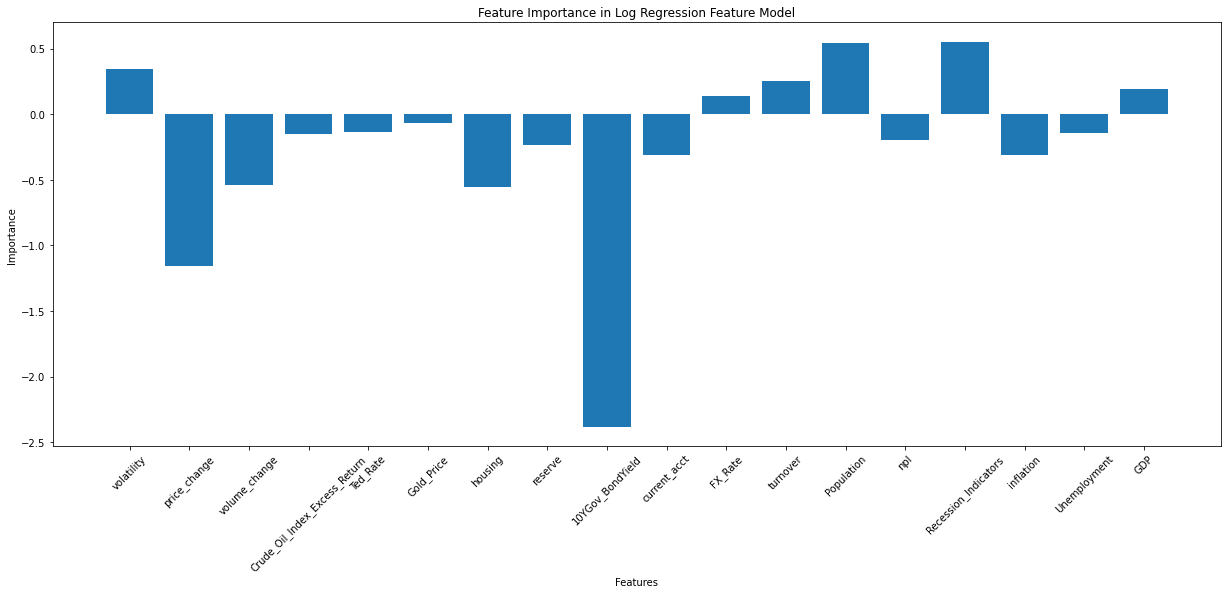

In [117]:
model_name = "Log Regression Feature"
plot_feature_importances(evaluation_df, model_name)

## Model Evaluation 
- Precision: number of True Positives / (number of True Positives + number of False Positives)
- Recall: number of True Positives / (number of True Positives + number of False Negatives)
- F1 score: A weighted average of precision and recall, F1 = 2*((precision*recall)/(precision+recall))

Crash Probability: 0.2753739411628631
AUC-ROC Score: 1.0


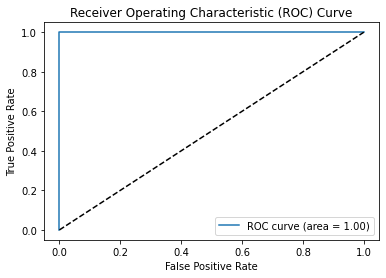

In [65]:
#Prediction Result
y_prob = model.predict_proba(X_test)
crash_prob = y_prob[:, 1]
print(f"Crash Probability: {crash_prob.mean()}")

#AUC_ROC
auc_roc = roc_auc_score(y_test, crash_prob)
print("AUC-ROC Score:", auc_roc)

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, -1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()